In [1]:
import torch
from torchvision import datasets, transforms, models
from torch.utils.data import DataLoader, Dataset
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torchsummary import summary
import os

from PIL import Image
import numpy as np
import matplotlib.pyplot as plt
from tqdm import tqdm

from skimage import io
import copy
import gc
from sklearn.svm import LinearSVC
from joblib import dump

In [2]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
Epochs = 18
classes = ["Cat", "Dog"]

In [3]:
# download dataset
# !wget -O dataset.tar.gz https://www.robots.ox.ac.uk/~vgg/data/pets/data/images.tar.gz
# !wget -O labels.tar.gz https://www.robots.ox.ac.uk/~vgg/data/pets/data/annotations.tar.gz


In [4]:
class Cat_Dog_Dataset(Dataset):
    def __init__(self, label_dir, data_dir, train, transform=None):
        np.random.seed(0)
        self.label_dir = label_dir
        self.data_dir = data_dir
        self.transform = transform
        self.train = train
        self.filter_dataset()
        
    def class_vise_idx(self, labels, size):
        all_cats = labels[labels[:, 2] == '1']
        filtered_cats = all_cats[np.random.choice(len(all_cats), size=size, replace=False)]

        all_dogs = labels[labels[:, 2] == '2']
        filtered_dogs = all_dogs[np.random.choice(len(all_dogs), size=size, replace=False)]
        filtered_labels = np.vstack((filtered_cats, filtered_dogs))
        return np.delete(filtered_labels, [1, -1], axis=1)
        
    def filter_dataset(self):
        if self.train:
            label_path = os.path.join(self.label_dir, "trainval.txt")
            labels = np.loadtxt(label_path, dtype=object)
            self.labels = self.class_vise_idx(labels, size=600)

        else:
            label_path = os.path.join(self.label_dir, "test.txt")
            labels = np.loadtxt(label_path, dtype=object)
            self.labels = self.class_vise_idx(labels, size=400)
            
    def t_transform(self, label, n_classes=2):
        sample = torch.eye(n_classes, dtype=int)
        if label == 1:
            return sample[0]
        if label == 2:
            return sample[1]
        
    def t(self, img):
        return self.transform(img)
        
    def __len__(self):
        return len(self.labels)
    
    def visual(self, img):
        plt.imshow(img)
        plt.show
    
    def __getitem__(self, idx):
        name, label = self.labels[idx]
        file_path = os.path.join(self.data_dir, name+'.jpg')
        img = np.array(Image.open(file_path).convert('RGB'))
        
        if self.transform:
            img = self.t(img)

        label = self.t_transform(int(label))
        return (img, label)

In [5]:
label_dir = "./data/annotations"
data_dir = "./data/images"

t = transforms.Compose([transforms.ToTensor(),
                        transforms.ColorJitter(brightness=.5, hue=.3),
                        transforms.GaussianBlur(kernel_size=(5, 9), sigma=(0.1, 5)),
                        transforms.RandomPerspective(distortion_scale=0.6, p=0.5),
                        transforms.RandomVerticalFlip(p=0.5),
                        transforms.Resize((224, 224)),
                        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225]),
                       ])

test_transform = transforms.Compose([transforms.ToTensor(),
                                     transforms.Resize((224, 224)),
                                     transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225]),
                       ])

train_dataset = Cat_Dog_Dataset(label_dir, data_dir, train=True, transform=t)
test_dataset = Cat_Dog_Dataset(label_dir, data_dir, train=False, transform=test_transform)

In [6]:
train_loader = DataLoader(train_dataset, batch_size=16, shuffle=True, num_workers=4, pin_memory=True)
test_loader = DataLoader(test_dataset, batch_size=16, shuffle=True, num_workers=4, pin_memory=True)

## Visualization of dataset with and without transformations 

Now that the dataset is ready for training, lets visualize it.

In [7]:
transformed_img = train_dataset[0][0].permute(1,2,0)
transformed_label = classes[torch.argmax(train_dataset[0][1]).item()]

untransformed_image = test_dataset[0][0].permute(1,2,0)
untransformed_label = classes[torch.argmax(test_dataset[0][1]).item()]

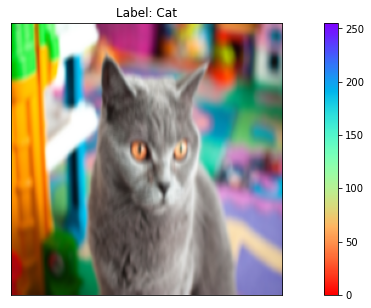

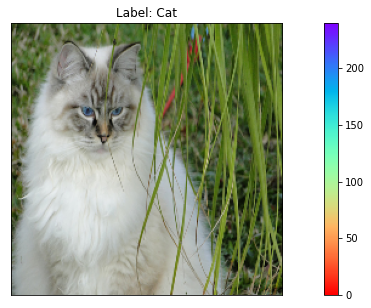

In [8]:
def visual(img, label):
    mean = np.array([0.485, 0.456, 0.406])
    std = np.array([0.229, 0.224, 0.225])
    img = ((img * std + mean) * 255).type(torch.uint8)

    fig, ax = plt.subplots()
    fig.set_size_inches(15,5)

    im = ax.imshow(img, cmap=plt.cm.rainbow_r)

    fig.colorbar(im)
    ax.set_title(f"Label: {label}")
    ax.set_xticks([])
    ax.set_yticks([])

visual(transformed_img, transformed_label)
visual(untransformed_image, untransformed_label)

In [50]:
def train(model, train_loader, optimizer, criterion, epoch, allow_cutmix):
    """
    Training for one epoch
    """
    loss_list = []
    running_loss = 0.0
    pbar = tqdm(enumerate(train_loader), total=len(train_loader))
    model.train()
    
    for idx, (images, labels) in pbar:
        if allow_cutmix:
            images, labels = generate_cutmix_image(images, labels, 1.0)
        
        # put on gpu
        images, labels = images.to(device), labels.type(torch.float32).to(device)
        model = model.to(device)
        
        optimizer.zero_grad()
        
        outputs = model(images)
        
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        
        loss_list.append(loss.item())
        running_loss =+ loss.item()
        
        if idx % 1 == 0:
            pbar.set_description(f"Epoch {epoch+1}, Itr {idx+1}, Loss {running_loss:.5f}")

    avg_loss = np.mean(loss_list)

    return loss_list, avg_loss

@torch.no_grad()
def testing(model, test_loader, criterion):
    """
    Testing the accuracy for validation set
    """
    model.eval()
    correct = 0
    loss_list = []
    for images, labels in test_loader:
        images, labels = images.to(device), labels.type(torch.float32).to(device)
        model = model.to(device)
        criterion = criterion.to(device)
        outputs = model(images)
        loss = criterion(outputs, labels)

        
        preds = torch.argmax(outputs, dim=1)
        gt = torch.argmax(labels, dim=1)
        
        loss_list.append(loss.item())
        correct += torch.count_nonzero(preds == gt)
    accuracy = correct / len(test_dataset)

    return accuracy, np.mean(loss_list)
        
def training_model(model, optimizer, scheduler, criterion, train_loader, valid_loader, num_epochs, allow_cutmix):
    """
    Training and testing of model for N number of EPOCHS
    """
    stats = {
        "epoch": [],
        "train_loss": [],
        "val_loss": [],
        "valid_acc": [],
        "loss_iters":[]
    }
    for epoch in range(num_epochs):
        # testing 
        acc, v_loss = testing(model, valid_loader, criterion)
        stats["valid_acc"].append(acc.item())
        stats["val_loss"].append(v_loss)
        
        # training epoch
        stats['epoch'].append(epoch+1)
        
        epoch_loss_list, epoch_loss = train(model, train_loader, optimizer, criterion, epoch, allow_cutmix)
        scheduler.step()
        
        stats["train_loss"].append(epoch_loss)
        stats["loss_iters"] = stats["loss_iters"] + epoch_loss_list
            

        if epoch == 0 or (epoch+1) % 3 == 0 or (epoch+1) == num_epochs:
            saving_model(model, optimizer, epoch, stats)
            print(f"Accuracy for epoch: {epoch+1} is ", np.round(stats["valid_acc"][-1]))       

    print(f"Training completed")

In [10]:
# util functions 
def generate_cutmix_image(input, target, beta):
    """ Generate a CutMix augmented image from a batch 
    Args:
        - image_batch: a batch of input images
        - image_batch_labels: labels corresponding to the image batch
        - beta: a parameter of Beta distribution.
    Returns:
        - CutMix image batch, updated labels
    Ref: "https://www.kaggle.com/debanga/cutmix-in-python"
    """
    lam = np.random.beta(beta, beta)
    rand_index = torch.randperm(input.size()[0])
    target_a = target
    target_b = target[rand_index]
    bbx1, bby1, bbx2, bby2 = rand_bbox(input.size(), lam)
    input[:, :, bbx1:bbx2, bby1:bby2] = input[rand_index, :, bbx1:bbx2, bby1:bby2]

    # adjust lambda to exactly match pixel ratio
    lam = 1 - ((bbx2 - bbx1) * (bby2 - bby1) / (input.size()[-1] * input.size()[-2]))

    return input, target

def rand_bbox(size, lam):
    W = size[2]
    H = size[3]
    cut_rat = np.sqrt(1. - lam)
    cut_w = int(W * cut_rat)
    cut_h = int(H * cut_rat)

    # uniform
    cx = np.random.randint(W)
    cy = np.random.randint(H)

    bbx1 = np.clip(cx - cut_w // 2, 0, W)
    bby1 = np.clip(cy - cut_h // 2, 0, H)
    bbx2 = np.clip(cx + cut_w // 2, 0, W)
    bby2 = np.clip(cy + cut_h // 2, 0, H)

    return bbx1, bby1, bbx2, bby2

def num_params(model):
    return sum(p.numel() for p in model.parameters() if p.requires_grad)

def saving_model(model, optimizer, epoch, stats):
    if not os.path.exists("models"):
        os.makedirs("models")
    save_path = f"models/{model.name}_{epoch+1}.pth"
    torch.save({
        'epoch' : epoch,
        'model_state_dict' : model.state_dict(),
        'optimizer_state_dict': optimizer.state_dict(),
        'stats': stats
    }, save_path)
    

def loading_model(model, path):
    optimizer = torch.optim.Adam(params=model.parameters(), lr= 3e-4)
    checkpoint =  torch.load(path)
    model.load_state_dict(checkpoint['model_state_dict'])
    optimizer.load_state_dict(checkpoint['optimizer_state_dict'])
    epoch = checkpoint['epoch']
    stats = checkpoint['stats']
    return model, optimizer, epoch, stats

## Memory allocation confusion

Okay so I saw that my model always remained on the GPU even tho I deleted the variable model from this function below and all the remaining refrences above.

So I specifically had to move the model to cpu and then run the following (below) commands to free the GPU memory. 

```
    gc.collect()
    torch.cuda.empty_cache()
```

In [11]:
def training_full_model(model, train_loader, valid_loader, num_epochs, allow_cutmix=True):
    LR = 3e-4
    criterion = nn.CrossEntropyLoss()
    optimizer = torch.optim.Adam(params=model.parameters(), lr=LR)
    scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=7, gamma=0.1)
    
    training_model(model, optimizer, scheduler, criterion, train_loader, valid_loader, num_epochs, allow_cutmix)

#     del model          # Deleting a model did not work
    model = model.to("cpu")
    print("Memory Allocated before gc ", torch.cuda.memory_allocated())


### Chaning models last layer as per our needs
Since VGG, Resnet and DenseNet are all trained on ImageNet challange, the output layer for all  these models have 1000 units. Thus first we need to change it as per our need which is 2 classes

In [12]:
# Should be changed as well
def fixed_or_finetuned(model_name: str, fixed: bool, custom_name=None):
    assert model_name in ["vgg", "resnet", "dense"]
    if model_name == "vgg":
        model = models.vgg16(pretrained=True)
        if fixed: 
            model.name = f"{model_name}_fixed"
            for param in model.parameters():
                param.requires_grad = False
        if not fixed:
            model.name = f"{model_name}_finetuned"
        model.classifier = nn.Sequential(
                                nn.Linear(in_features=25088, out_features=4096),
                                nn.ReLU(inplace=True),
                                nn.Dropout(p=0.5, inplace=False),
                                nn.Linear(in_features=4096, out_features=4096),
                                nn.ReLU(inplace=True),
                                nn.Dropout(p=0.5, inplace=False),
                                nn.Linear(in_features=4096, out_features=1000),
                                nn.ReLU(inplace=True),
                                nn.Linear(in_features=1000, out_features=2))
    
    if model_name == "resnet":
        model = models.resnet18(pretrained=True)
        if fixed: 
            model.name = f"{model_name}_fixed"
            for param in model.parameters():
                param.requires_grad = False
        if not fixed: 
            model.name = f"{model_name}_finetuned"
        model.fc = nn.Sequential(
                        nn.Linear(512, 256),
                        nn.ReLU(),
                        nn.Linear(256, 2))
    
    if model_name == "dense":
        model = models.densenet161(pretrained=True)
        if fixed: 
            model.name = f"{model_name}_fixed"
        if not fixed: 
            model.name = f"{model_name}_finetuned"
        model.classifier = nn.Sequential(
                                    nn.Linear(2208, 512),
                                    nn.ReLU(),
                                    nn.Linear(512, 2))
    if custom_name:
        model.name = custom_name
    return model

## Fine tuned VGG, ResNet and DenseNet training

### Model declaration

In [13]:
resnet_finetuned = fixed_or_finetuned(model_name="resnet", fixed=False)
vgg_finetuned = fixed_or_finetuned(model_name="vgg", fixed=False)
dense_finetuned = fixed_or_finetuned(model_name="dense", fixed=False)

### Model training 

In [18]:
%time training_full_model(model=resnet_finetuned, train_loader=train_loader, valid_loader=test_loader, num_epochs=Epochs)

Epoch 1, Itr 75, Loss 0.70070: 100%|████████████| 75/75 [00:16<00:00,  4.67it/s]


Accuracy for epoch: 1 is  0.6937499642372131


Epoch 3, Itr 75, Loss 0.59358: 100%|████████████| 75/75 [00:15<00:00,  4.81it/s]


Accuracy for epoch: 3 is  0.8887499570846558


Epoch 6, Itr 75, Loss 0.38736: 100%|████████████| 75/75 [00:16<00:00,  4.60it/s]


Accuracy for epoch: 6 is  0.8324999809265137


Epoch 9, Itr 75, Loss 0.86471: 100%|████████████| 75/75 [00:15<00:00,  4.91it/s]


Accuracy for epoch: 9 is  0.8725000023841858


Epoch 12, Itr 75, Loss 0.39012: 100%|███████████| 75/75 [00:16<00:00,  4.65it/s]


Accuracy for epoch: 12 is  0.8899999856948853


Epoch 15, Itr 75, Loss 0.28973: 100%|███████████| 75/75 [00:15<00:00,  4.72it/s]


Accuracy for epoch: 15 is  0.9049999713897705


Epoch 18, Itr 75, Loss 0.31916: 100%|███████████| 75/75 [00:15<00:00,  4.73it/s]


Accuracy for epoch: 18 is  0.9149999618530273
Training completed
Memory Allocated before gc  91423744
CPU times: user 2min 36s, sys: 8.72 s, total: 2min 45s
Wall time: 5min 14s


In [19]:
gc.collect()
torch.cuda.empty_cache()
print("Memory Allocated now: ", torch.cuda.memory_allocated())
print("Memory Reserved: ", torch.cuda.memory_reserved())

Memory Allocated now:  0
Memory Reserved:  0


In [14]:
%time training_full_model(model=dense_finetuned, train_loader=train_loader, valid_loader=test_loader, num_epochs=Epochs)

Epoch 1, Itr 75, Loss 0.59469: 100%|████████████| 75/75 [00:28<00:00,  2.59it/s]


Accuracy for epoch: 1 is  0.6037499904632568


Epoch 3, Itr 75, Loss 0.50948: 100%|████████████| 75/75 [00:28<00:00,  2.68it/s]


Accuracy for epoch: 3 is  0.6462500095367432


Epoch 6, Itr 75, Loss 0.75696: 100%|████████████| 75/75 [00:28<00:00,  2.65it/s]


Accuracy for epoch: 6 is  0.8487499952316284


Epoch 9, Itr 75, Loss 0.57597: 100%|████████████| 75/75 [00:28<00:00,  2.64it/s]


Accuracy for epoch: 9 is  0.90625


Epoch 12, Itr 75, Loss 0.66319: 100%|███████████| 75/75 [00:28<00:00,  2.64it/s]


Accuracy for epoch: 12 is  0.918749988079071


Epoch 15, Itr 75, Loss 0.65584: 100%|███████████| 75/75 [00:28<00:00,  2.60it/s]


Accuracy for epoch: 15 is  0.9199999570846558


Epoch 18, Itr 75, Loss 0.29824: 100%|███████████| 75/75 [00:28<00:00,  2.63it/s]


Accuracy for epoch: 18 is  0.9237499833106995
Training completed
Memory Allocated before gc  224796672
CPU times: user 8min 7s, sys: 3min 5s, total: 11min 12s
Wall time: 10min 29s


In [15]:
gc.collect()
torch.cuda.empty_cache()
print("Memory Allocated now ", torch.cuda.memory_allocated())

Memory Allocated now  0


In [16]:
%time training_full_model(model=vgg_finetuned, train_loader=train_loader, valid_loader=test_loader, num_epochs=Epochs)

Epoch 1, Itr 75, Loss 0.69417: 100%|████████████| 75/75 [00:21<00:00,  3.46it/s]


Accuracy for epoch: 1 is  0.5512499809265137


Epoch 3, Itr 75, Loss 0.69224: 100%|████████████| 75/75 [00:20<00:00,  3.58it/s]


Accuracy for epoch: 3 is  0.5


Epoch 6, Itr 75, Loss 0.69414: 100%|████████████| 75/75 [00:21<00:00,  3.56it/s]


Accuracy for epoch: 6 is  0.5


Epoch 9, Itr 75, Loss 0.69276: 100%|████████████| 75/75 [00:20<00:00,  3.60it/s]


Accuracy for epoch: 9 is  0.5


Epoch 12, Itr 75, Loss 0.69335: 100%|███████████| 75/75 [00:21<00:00,  3.43it/s]


Accuracy for epoch: 12 is  0.5


Epoch 15, Itr 75, Loss 0.69443: 100%|███████████| 75/75 [00:21<00:00,  3.56it/s]


Accuracy for epoch: 15 is  0.5


Epoch 18, Itr 75, Loss 0.69342: 100%|███████████| 75/75 [00:21<00:00,  3.57it/s]


Accuracy for epoch: 18 is  0.5
Training completed
Memory Allocated before gc  1108714496
CPU times: user 8min 14s, sys: 16 s, total: 8min 30s
Wall time: 7min 53s


In [17]:
gc.collect()
torch.cuda.empty_cache()
print("Memory Allocated now ", torch.cuda.memory_allocated())

Memory Allocated now  0


## ResNet as Fixed Feature Extractor training

In [19]:
resnet_fixed = fixed_or_finetuned(model_name="resnet", fixed=True)

In [20]:
%time training_full_model(model=resnet_fixed, train_loader=train_loader, valid_loader=test_loader, num_epochs=Epochs)

Epoch 1, Itr 75, Loss 0.60385: 100%|████████████| 75/75 [00:15<00:00,  4.75it/s]

Accuracy for epoch: 1 is  0.543749988079071



Epoch 3, Itr 75, Loss 0.46325: 100%|████████████| 75/75 [00:16<00:00,  4.51it/s]

Accuracy for epoch: 3 is  0.9300000071525574



Epoch 6, Itr 75, Loss 0.61213: 100%|████████████| 75/75 [00:15<00:00,  4.95it/s]

Accuracy for epoch: 6 is  0.92249995470047



Epoch 9, Itr 75, Loss 0.51648: 100%|████████████| 75/75 [00:15<00:00,  4.89it/s]


Accuracy for epoch: 9 is  0.9375


Epoch 12, Itr 75, Loss 0.54277: 100%|███████████| 75/75 [00:16<00:00,  4.45it/s]


Accuracy for epoch: 12 is  0.9350000023841858


Epoch 15, Itr 75, Loss 0.60801: 100%|███████████| 75/75 [00:15<00:00,  4.94it/s]


Accuracy for epoch: 15 is  0.9249999523162842


Epoch 18, Itr 75, Loss 0.52418: 100%|███████████| 75/75 [00:15<00:00,  4.86it/s]


Accuracy for epoch: 18 is  0.9237499833106995
Training completed
Memory Allocated before gc  131041280
CPU times: user 1min 50s, sys: 8.57 s, total: 1min 58s
Wall time: 5min 9s


### Loading models from disk

In [20]:
# model definition
resnet_epoch_18 = fixed_or_finetuned(model_name="resnet", fixed=False)
dense_epoch_18 = fixed_or_finetuned(model_name="dense", fixed=False)
vgg_epoch_18 = fixed_or_finetuned(model_name="vgg", fixed=False)
resnet_fixed_epoch_18 = fixed_or_finetuned(model_name="resnet", fixed=True)

#loading models
resnet_epoch_18, _, _, stats_resnet_finetuned = loading_model(resnet_epoch_18, "models/resnet_finetuned_18.pth")
dense_epoch_18, _, _, stats_dense_finetuned = loading_model(dense_epoch_18, "models/dense_finetuned_18.pth")
vgg_epoch_18, _, _, stats_vgg_finetuned = loading_model(vgg_epoch_18, "models/vgg_finetuned_18.pth")
resnet_fixed_epoch_18, _, _, stats_resnet_fixed_epoch18 = loading_model(resnet_fixed_epoch_18, "models/resnet_fixed_18.pth")

## Comparison Plots for various models

### a) Fine Tuned VGG, ResNet and DenseNet
Below are the comparisons for all the fine tuned models. There are some important points to be noted:

* The train and valid loss plots are quite unique and interesting. The validation loss is quite less than the training loss which is not a usual scenerio while training a deep learning model. There are some comments about it in the *Experimental* section below

* In ResNet and DenseNet accuracy fluctuates quite a bit in the begining of the training but settles down at around 7th epoch and then starts rising

* Unfortunately, after many attempts to revive VGG, its loss never decreased and the accuracy remained 50% which is as good as random guess. Still the failure of VGG is unknown

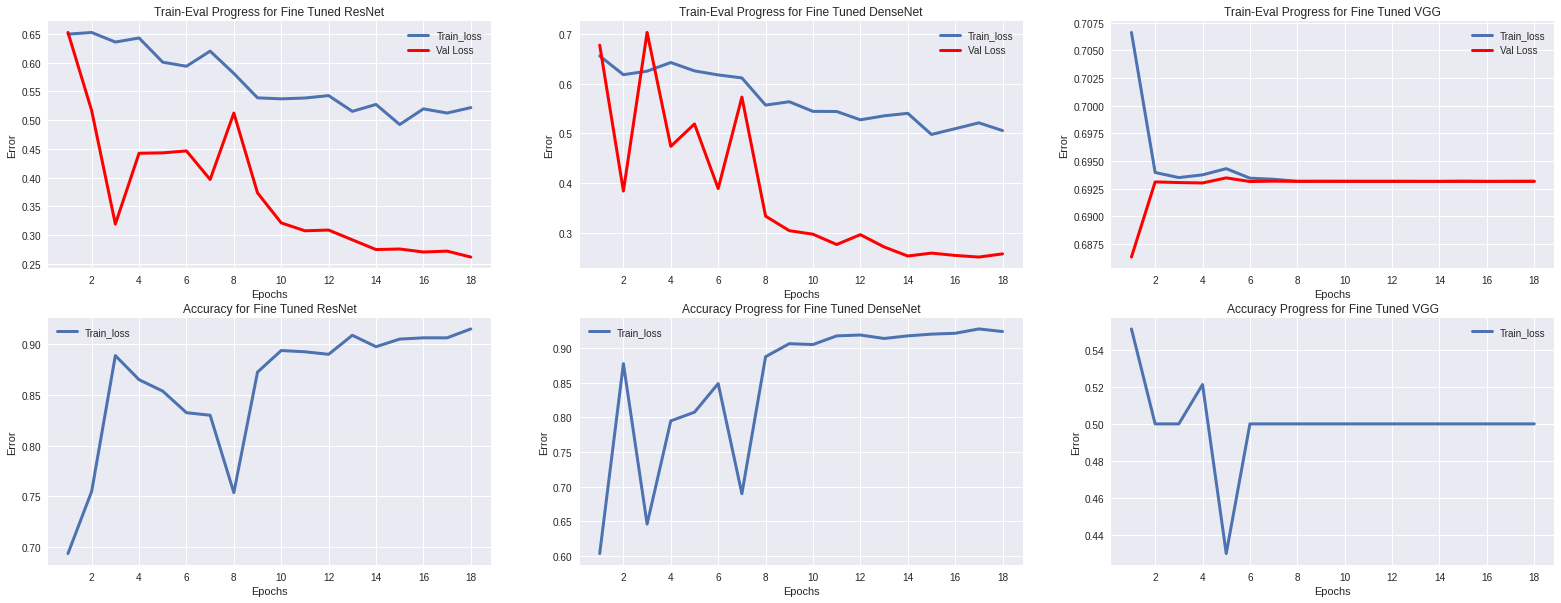

In [28]:
plt.style.use('seaborn')
fig, ax = plt.subplots(2,3)
fig.set_size_inches(27, 10)
# train and val loss
ax[0][0].plot(stats_resnet_finetuned['epoch'], stats_resnet_finetuned['train_loss'], label="Train_loss", linewidth=3)
ax[0][0].plot(stats_resnet_finetuned['epoch'], stats_resnet_finetuned['val_loss'], label="Val Loss", c='red', linewidth=3)
ax[0][0].legend(loc='best')
ax[0][0].set_xlabel("Epochs")
ax[0][0].set_ylabel("Error")
ax[0][0].set_xticks(np.arange(2, 19, step=2))

ax[0][0].set_title("Train-Eval Progress for Fine Tuned ResNet")


ax[0][1].plot(stats_dense_finetuned['epoch'], stats_dense_finetuned['train_loss'], label="Train_loss", linewidth=3)
ax[0][1].plot(stats_dense_finetuned['epoch'], stats_dense_finetuned['val_loss'], label="Val Loss", c='red', linewidth=3)
ax[0][1].legend(loc='best')
ax[0][1].set_xlabel("Epochs")
ax[0][1].set_ylabel("Error")
ax[0][1].set_xticks(np.arange(2, 19, step=2))

ax[0][1].set_title("Train-Eval Progress for Fine Tuned DenseNet")

ax[0][2].plot(stats_vgg_finetuned['epoch'], stats_vgg_finetuned['train_loss'], label="Train_loss", linewidth=3)
ax[0][2].plot(stats_vgg_finetuned['epoch'], stats_vgg_finetuned['val_loss'], label="Val Loss", c='red', linewidth=3)
ax[0][2].legend(loc='best')
ax[0][2].set_xlabel("Epochs")
ax[0][2].set_ylabel("Error")
ax[0][2].set_xticks(np.arange(2, 19, step=2))

ax[0][2].set_title("Train-Eval Progress for Fine Tuned VGG")

# accuracy
ax[1][0].plot(stats_resnet_finetuned['epoch'], stats_resnet_finetuned['valid_acc'], label="Train_loss", linewidth=3)
# ax[1][0].plot(stats_resnet_finetuned['epoch'], stats_resnet_finetuned['val_loss'], label="Val Loss", c='red', linewidth=3)
ax[1][0].legend(loc='best')
ax[1][0].set_xlabel("Epochs")
ax[1][0].set_ylabel("Error")
ax[1][0].set_xticks(np.arange(2, 19, step=2))

ax[1][0].set_title("Accuracy for Fine Tuned ResNet")


ax[1][1].plot(stats_dense_finetuned['epoch'], stats_dense_finetuned['valid_acc'], label="Train_loss", linewidth=3)
# ax[1][1].plot(stats_dense_finetuned['epoch'], stats_dense_finetuned['val_loss'], label="Val Loss", c='red', linewidth=3)
ax[1][1].legend(loc='best')
ax[1][1].set_xlabel("Epochs")
ax[1][1].set_ylabel("Error")
ax[1][1].set_xticks(np.arange(2, 19, step=2))

ax[1][1].set_title("Accuracy Progress for Fine Tuned DenseNet")


ax[1][2].plot(stats_vgg_finetuned['epoch'], stats_vgg_finetuned['valid_acc'], label="Train_loss", linewidth=3)
# ax[1][2].plot(stats_vgg_finetuned['epoch'], stats_vgg_finetuned['val_loss'], label="Val Loss", c='red', linewidth=3)
ax[1][2].legend(loc='best')
ax[1][2].set_xlabel("Epochs")
ax[1][2].set_ylabel("Error")
ax[1][2].set_xticks(np.arange(2, 19, step=2))

ax[1][2].set_title("Accuracy Progress for Fine Tuned VGG")


plt.show()

### b) Fixed backbone ResNet v/s Fine Tuned ResNet

Below are the plots for fixed backbone ResNet and Fine Tuned backbone ResNet. Here are some important points:

* Similar trend of train and valid loss is seen here as well. 

* It is seen that when the backbone is frozen and changes are made just on the MLP classifier the accuracy is around 5% higher.

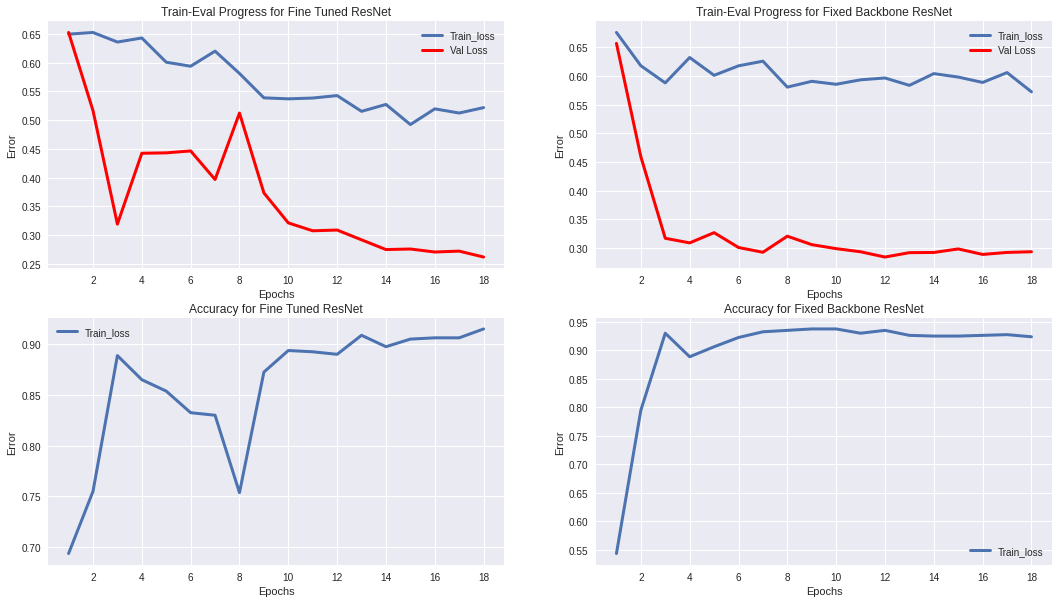

In [31]:
fig, ax = plt.subplots(2,2)
fig.set_size_inches(18, 10)

# train valid loss
ax[0][0].plot(stats_resnet_finetuned['epoch'], stats_resnet_finetuned['train_loss'], label="Train_loss", linewidth=3)
ax[0][0].plot(stats_resnet_finetuned['epoch'], stats_resnet_finetuned['val_loss'], label="Val Loss", c='red', linewidth=3)
ax[0][0].legend(loc='best')
ax[0][0].set_xlabel("Epochs")
ax[0][0].set_ylabel("Error")
ax[0][0].set_xticks(np.arange(2, 19, step=2))

ax[0][0].set_title("Train-Eval Progress for Fine Tuned ResNet")


ax[0][1].plot(stats_resnet_fixed_epoch18['epoch'], stats_resnet_fixed_epoch18['train_loss'], label="Train_loss", linewidth=3)
ax[0][1].plot(stats_resnet_fixed_epoch18['epoch'], stats_resnet_fixed_epoch18['val_loss'], label="Val Loss", c='red', linewidth=3)
ax[0][1].legend(loc='best')
ax[0][1].set_xlabel("Epochs")
ax[0][1].set_ylabel("Error")
ax[0][1].set_xticks(np.arange(2, 19, step=2))
ax[0][1].set_title("Train-Eval Progress for Fixed Backbone ResNet")

# accuracy
ax[1][0].plot(stats_resnet_finetuned['epoch'], stats_resnet_finetuned['valid_acc'], label="Train_loss", linewidth=3)
ax[1][0].legend(loc='best')
ax[1][0].set_xlabel("Epochs")
ax[1][0].set_ylabel("Error")
ax[1][0].set_xticks(np.arange(2, 19, step=2))

ax[1][0].set_title("Accuracy for Fine Tuned ResNet")


ax[1][1].plot(stats_resnet_fixed_epoch18['epoch'], stats_resnet_fixed_epoch18['valid_acc'], label="Train_loss", linewidth=3)
ax[1][1].legend(loc='best')
ax[1][1].set_xlabel("Epochs")
ax[1][1].set_ylabel("Error")
ax[1][1].set_xticks(np.arange(2, 19, step=2))

ax[1][1].set_title("Accuracy for Fixed Backbone ResNet")

plt.show()

## Experimental

So now we see that the val loss is much lower than the training loss. The suspected reasons are:
1. Heavy regularization (CutMix) that we applied in the training and not in the testing scenerio. 

2. Validation set may be easier than training

So lets prove this reasoning by training another ResNet model without CutMix.

*Reference: https://www.pyimagesearch.com/2019/10/14/why-is-my-validation-loss-lower-than-my-training-loss/*

In [23]:
resnet_no_cutmix = fixed_or_finetuned(model_name="resnet", fixed=False, custom_name="exp_resnet")
%time training_full_model(model=resnet_no_cutmix, train_loader=train_loader, valid_loader=test_loader, num_epochs=Epochs, allow_cutmix=False)

Epoch 1, Itr 75, Loss 0.21654: 100%|████████████| 75/75 [00:15<00:00,  4.75it/s]


Accuracy for epoch: 1 is  0.48624998331069946


Epoch 3, Itr 75, Loss 0.24620: 100%|████████████| 75/75 [00:14<00:00,  5.00it/s]


Accuracy for epoch: 3 is  0.7099999785423279


Epoch 6, Itr 75, Loss 0.16557: 100%|████████████| 75/75 [00:15<00:00,  4.81it/s]


Accuracy for epoch: 6 is  0.9412499666213989


Epoch 9, Itr 75, Loss 0.05890: 100%|████████████| 75/75 [00:15<00:00,  4.95it/s]


Accuracy for epoch: 9 is  0.9474999904632568


Epoch 12, Itr 75, Loss 0.01411: 100%|███████████| 75/75 [00:15<00:00,  4.89it/s]


Accuracy for epoch: 12 is  0.9649999737739563


Epoch 15, Itr 75, Loss 0.06589: 100%|███████████| 75/75 [00:14<00:00,  5.07it/s]


Accuracy for epoch: 15 is  0.9649999737739563


Epoch 18, Itr 75, Loss 0.09290: 100%|███████████| 75/75 [00:14<00:00,  5.04it/s]


Accuracy for epoch: 18 is  0.9712499976158142
Training completed
Memory Allocated before gc  94012416
CPU times: user 1min 38s, sys: 9.47 s, total: 1min 47s
Wall time: 5min 9s


In [38]:
resnet_no_cutmix_epoch18 = fixed_or_finetuned(model_name="resnet", fixed=False, custom_name="exp_resnet")
resnet_no_cutmix_epoch18, _, _, stats_resnet_no_cutmix_epoch18 = loading_model(resnet_fixed_epoch_18, "models/exp_resnet_18.pth")

### Comparion with Fixed ResNet model

Below are the comparion plots. Here are some important points:

* As suspected now the valid loss has an expected trend and the gap that we can see in the plot on the left is where CutMix was applied is much larger than the model on the left where CutMix was not applied.

* In the performance accuracy as well, the max accuracy for the model without CutMix is ~97% which is ~2-3% higher than the ResNet model with frozen backbone

This proves that our hypothesis was correct and the reason for this Train-Val loss gap was rigorous regularization 

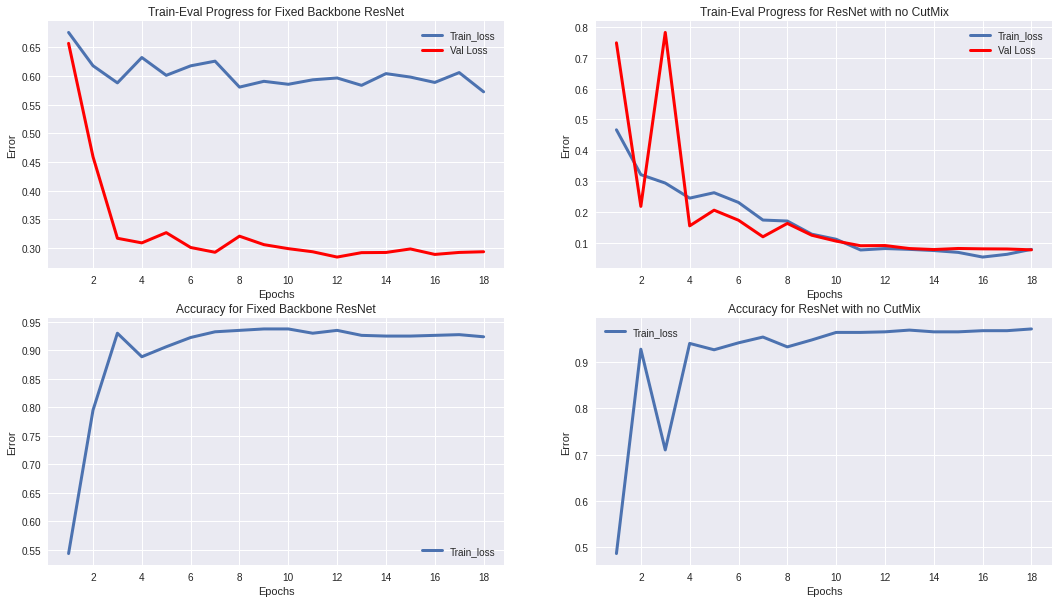

In [41]:
fig, ax = plt.subplots(2,2)
fig.set_size_inches(18, 10)


# train valid loss
ax[0][0].plot(stats_resnet_fixed_epoch18['epoch'], stats_resnet_fixed_epoch18['train_loss'], label="Train_loss", linewidth=3)
ax[0][0].plot(stats_resnet_fixed_epoch18['epoch'], stats_resnet_fixed_epoch18['val_loss'], label="Val Loss", c='red', linewidth=3)
ax[0][0].legend(loc='best')
ax[0][0].set_xlabel("Epochs")
ax[0][0].set_ylabel("Error")
ax[0][0].set_xticks(np.arange(2, 19, step=2))

ax[0][0].set_title("Train-Eval Progress for Fixed Backbone ResNet")

ax[0][1].plot(stats_resnet_no_cutmix_epoch18['epoch'], stats_resnet_no_cutmix_epoch18['train_loss'], label="Train_loss", linewidth=3)
ax[0][1].plot(stats_resnet_no_cutmix_epoch18['epoch'], stats_resnet_no_cutmix_epoch18['val_loss'], label="Val Loss", c='red', linewidth=3)
ax[0][1].legend(loc='best')
ax[0][1].set_xlabel("Epochs")
ax[0][1].set_ylabel("Error")
ax[0][1].set_xticks(np.arange(2, 19, step=2))

ax[0][1].set_title("Train-Eval Progress for ResNet with no CutMix")


# accuracy
ax[1][0].plot(stats_resnet_fixed_epoch18['epoch'], stats_resnet_fixed_epoch18['valid_acc'], label="Train_loss", linewidth=3)
ax[1][0].legend(loc='best')
ax[1][0].set_xlabel("Epochs")
ax[1][0].set_ylabel("Error")
ax[1][0].set_xticks(np.arange(2, 19, step=2))

ax[1][0].set_title("Accuracy for Fixed Backbone ResNet")


ax[1][1].plot(stats_resnet_no_cutmix_epoch18['epoch'], stats_resnet_no_cutmix_epoch18['valid_acc'], label="Train_loss", linewidth=3)
ax[1][1].legend(loc='best')
ax[1][1].set_xlabel("Epochs")
ax[1][1].set_ylabel("Error")
ax[1][1].set_xticks(np.arange(2, 19, step=2))

ax[1][1].set_title("Accuracy for ResNet with no CutMix")

plt.show()

## ResNet with SVM classifier

Here in this task we need to extract features with ResNet and then train an SVM classifier on top of these features. This means that the MLP that we used in earlier models should be replaced by this SVM classifier.

In [42]:
class Identity(nn.Module):
    def __init__(self):
        super(Identity, self).__init__()
        
    def forward(self, x):
        return x

In [64]:
def extract_features(model, dataset):
    model.fc = Identity()
    model.eval()
    model.to(device)
    img_features, targets = np.zeros((len(dataset), 512)), np.zeros(len(dataset))
    for idx, (img, labels) in enumerate(dataset):
        with torch.no_grad():
            img, label = img.to(device), labels.type(torch.float32).to(device)
            img = torch.unsqueeze(img, 0)
            feature = model(img)
            img_features[idx] = feature.cpu()
            targets[idx] = torch.argmax(label).cpu()
    np.save("features", img_features)
    np.save("targets", targets)
    return img_features, targets

def SVM_acc(classifier, features, targets):
    correct = 0
    for feature, target in zip(features, targets):
        pred = classifier.predict(feature.reshape(1, -1))
        if pred[0] == target:
            correct += 1
        
    return (correct/len(targets)) * 100

In [57]:
# First extract features and store them as np array with labels on disk
train_features, train_targets = extract_features(resnet_finetuned, train_dataset)
test_features, test_targets = extract_features(resnet_finetuned, test_dataset)

In [58]:
# Make SVM Classifier
clf = LinearSVC(
    max_iter=20000,
    random_state=42,
    dual=False,
    verbose=1
)
clf.fit(train_features, train_targets)

# Save this classifier
dump(clf, 'models/resnet18_svm.joblib')

[LibLinear]iter  1 act 8.875e+02 pre 8.522e+02 delta 5.788e-02 f 1.200e+03 |g| 3.084e+04 CG   2
iter  2 act 5.940e+01 pre 4.766e+01 delta 5.788e-02 f 3.125e+02 |g| 4.312e+03 CG   3
cg reaches trust region boundary
iter  3 act 2.505e+01 pre 2.138e+01 delta 7.976e-02 f 2.531e+02 |g| 1.615e+03 CG   4
cg reaches trust region boundary
iter  4 act 1.431e+01 pre 1.360e+01 delta 1.671e-01 f 2.280e+02 |g| 5.573e+02 CG   3
cg reaches trust region boundary
iter  5 act 1.332e+01 pre 1.289e+01 delta 1.738e-01 f 2.137e+02 |g| 1.719e+02 CG   3
cg reaches trust region boundary
iter  6 act 2.046e+01 pre 2.029e+01 delta 2.175e-01 f 2.004e+02 |g| 4.194e+02 CG   4
cg reaches trust region boundary
iter  7 act 1.641e+01 pre 1.697e+01 delta 2.593e-01 f 1.799e+02 |g| 2.576e+02 CG   5
cg reaches trust region boundary
iter  8 act 1.989e+01 pre 1.918e+01 delta 4.150e-01 f 1.635e+02 |g| 2.864e+02 CG   5
cg reaches trust region boundary
iter  9 act 2.172e+01 pre 2.144e+01 delta 7.108e-01 f 1.436e+02 |g| 1.683e+02 

['models/resnet18_svm.joblib']

In [68]:
svm_acc = SVM_acc(clf, test_features, test_targets)
max_finetuned = max(stats_resnet_finetuned["valid_acc"])
max_fixed_acc = max(stats_resnet_fixed_epoch18["valid_acc"])

In [75]:
print(f"Accuracy of Finetuned ResNet plus MLP classifier is: {np.round(max_finetuned * 100, 3)}")
print(f"Accuracy of Fixed ResNet plus MLP classifier is: {max_fixed_acc * 100}")
print(f"Accuracy of ResNet plus SVM classifier is: {svm_acc}")

Accuracy of Finetuned ResNet plus MLP classifier is: 91.5
Accuracy of Fixed ResNet plus MLP classifier is: 93.75
Accuracy of ResNet plus SVM classifier is: 91.625


This comparison shows that out of the 3 models the ResNet model with fixed backbone performed the best. For the second spot both finetuned ResNet and ResNet with SVM performed equally better, but ResNet with SVM was marginally ahead with accuracy of 91.625 